In [1]:
pip install scikit-learn scikit-image scipy seaborn matplotlib numpy opencv-python pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [3]:
data_awal = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)

        if img is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue
        
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, (256, 700))  
        
        data_awal.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data_awal = np.array(data_awal)
labels = np.array(labels)


# Augmentasi


In [ ]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

def augment_flip(img: np.ndarray) -> np.ndarray:
    return cv.flip(img, 1)          

target_per_label = 100

label2idx = {}
for idx, lab in enumerate(labels):
    label2idx.setdefault(lab, []).append(idx)

for lab, idx_list in label2idx.items():
    existing = len(idx_list)                       
    need = target_per_label - existing          
    for n in range(need):
        base_idx  = idx_list[n % existing]         
        base_img  = data_awal[base_idx]
        aug_img   = augment_flip(base_img)       

        data_augmented.append(aug_img)
        labels_augmented.append(lab)

        new_name = f"{lab}_flip{n:04d}.png"
        file_name_augmented.append(new_name)
        paths_augmented.append(
            os.path.join("dataset_aug", lab, new_name))

data_final   = np.concatenate([data_awal, np.array(data_augmented)], axis=0)
labels_final = np.concatenate([labels,     np.array(labels_augmented)], axis=0)
file_name_final = np.concatenate([file_name, np.array(file_name_augmented)], axis=0)
print("Data sebelum augmentasi :", len(data_awal))   # 142
print("Data setelah  augmentasi :", len(data_final)) # 200


Data sebelum augmentasi : 142
Data setelah  augmentasi : 200


### Feature Extraction

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [10]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [11]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [12]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [13]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [14]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [15]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [16]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [18]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_final)):
    D0 = glcm(data_final[i], 0)
    D45 = glcm(data_final[i], 45)
    D90 = glcm(data_final[i], 90)
    D135 = glcm(data_final[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [19]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [21]:
for i in range(len(data_final)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [22]:
for i in range(len(data_final)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [23]:
for i in range(len(data_final)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [24]:
for i in range(len(data_final)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [25]:
for i in range(len(data_final)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [26]:
for i in range(len(data_final)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [27]:
for i in range(len(data_final)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [28]:
dataTable = {'Filename': file_name_final, 'Label': labels_final,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


Filename        Label   Contrast0  Contrast45  Contrast90  \
0         N1,N,40,M_1_0.jpg  NormalFinal   51.518331  199.468967  157.777277   
1         N1,N,F,21_1_0.jpg  NormalFinal  104.691810  285.578945  204.050479   
2        N11,N,F,26_1_0.jpg  NormalFinal   23.067838   67.781150   51.911157   
3        N12,N,F,14_1_0.jpg  NormalFinal    9.786997   30.819838   22.067060   
4        N12,N,M,13_1_0.jpg  NormalFinal   12.771473   33.320480   23.986370   
..                      ...          ...         ...         ...         ...   
195  ScolFinal_flip0024.png    ScolFinal    9.921311   19.972381   11.969946   
196  ScolFinal_flip0025.png    ScolFinal   42.876504  174.126365  141.108408   
197  ScolFinal_flip0026.png    ScolFinal   82.640605  142.386025   83.209563   
198  ScolFinal_flip0027.png    ScolFinal   90.877221  113.320289   49.263742   
199  ScolFinal_flip0028.png    ScolFinal   18.435406   45.368616   35.516519   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     193.901922      0.431314       0.330260       0.380965        0.330628   
1     279.649482      0.327769       0.246749       0.304987        0.258245   
2      68.153570      0.421461       0.307511       0.340640        0.302484   
3      29.777638      0.450064       0.314988       0.357346        0.313257   
4      34.945098      0.458863       0.365226       0.419087        0.359991   
..           ...           ...            ...            ...             ...   
195    20.405363      0.458807       0.361665       0.423928        0.362607   
196   172.372341      0.413592       0.328081       0.397957        0.323447   
197   149.647704      0.406051       0.363565       0.446198        0.358751   
198   115.981856      0.383480       0.352847       0.444093        0.347868   
199    52.126079      0.391374       0.280052       0.314378        0.275448   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.000847  0.000696  0.031756  0.026233  0.029112   0.026385   
1    ...  0.000768  0.000652  0.028567  0.024874  0.027717   0.025543   
2    ...  0.003042  0.002840  0.057771  0.053430  0.055153   0.053289   
3    ...  0.000863  0.000731  0.035311  0.026929  0.029377   0.027035   
4    ...  0.005832  0.005480  0.077070  0.074164  0.076365   0.074026   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.001107  0.000885  0.035466  0.029679  0.033275   0.029755   
196  ...  0.000913  0.000723  0.031508  0.027034  0.030210   0.026880   
197  ...  0.006177  0.005263  0.076130  0.072855  0.078594   0.072547   
198  ...  0.004229  0.003224  0.060393  0.057707  0.065031   0.056777   
199  ...  0.000590  0.000494  0.028218  0.022658  0.024291   0.022235   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.987027       0.949662       0.960266        0.951067  
1        0.984659       0.958001       0.970014        0.958874  
2        0.992665       0.978384       0.983445        0.978265  
3        0.996089       0.987667       0.991171        0.988084  
4        0.995645       0.988587       0.991785        0.988031  
..            ...            ...            ...             ...  
195      0.995625       0.991172       0.994714        0.990981  
196      0.989128       0.955835       0.964505        0.956281  
197      0.985800       0.975497       0.985699        0.974248  
198      0.982877       0.978583       0.990695        0.978080  
199      0.995549       0.989012       0.991418        0.987376  

[200 rows x 30 columns]

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

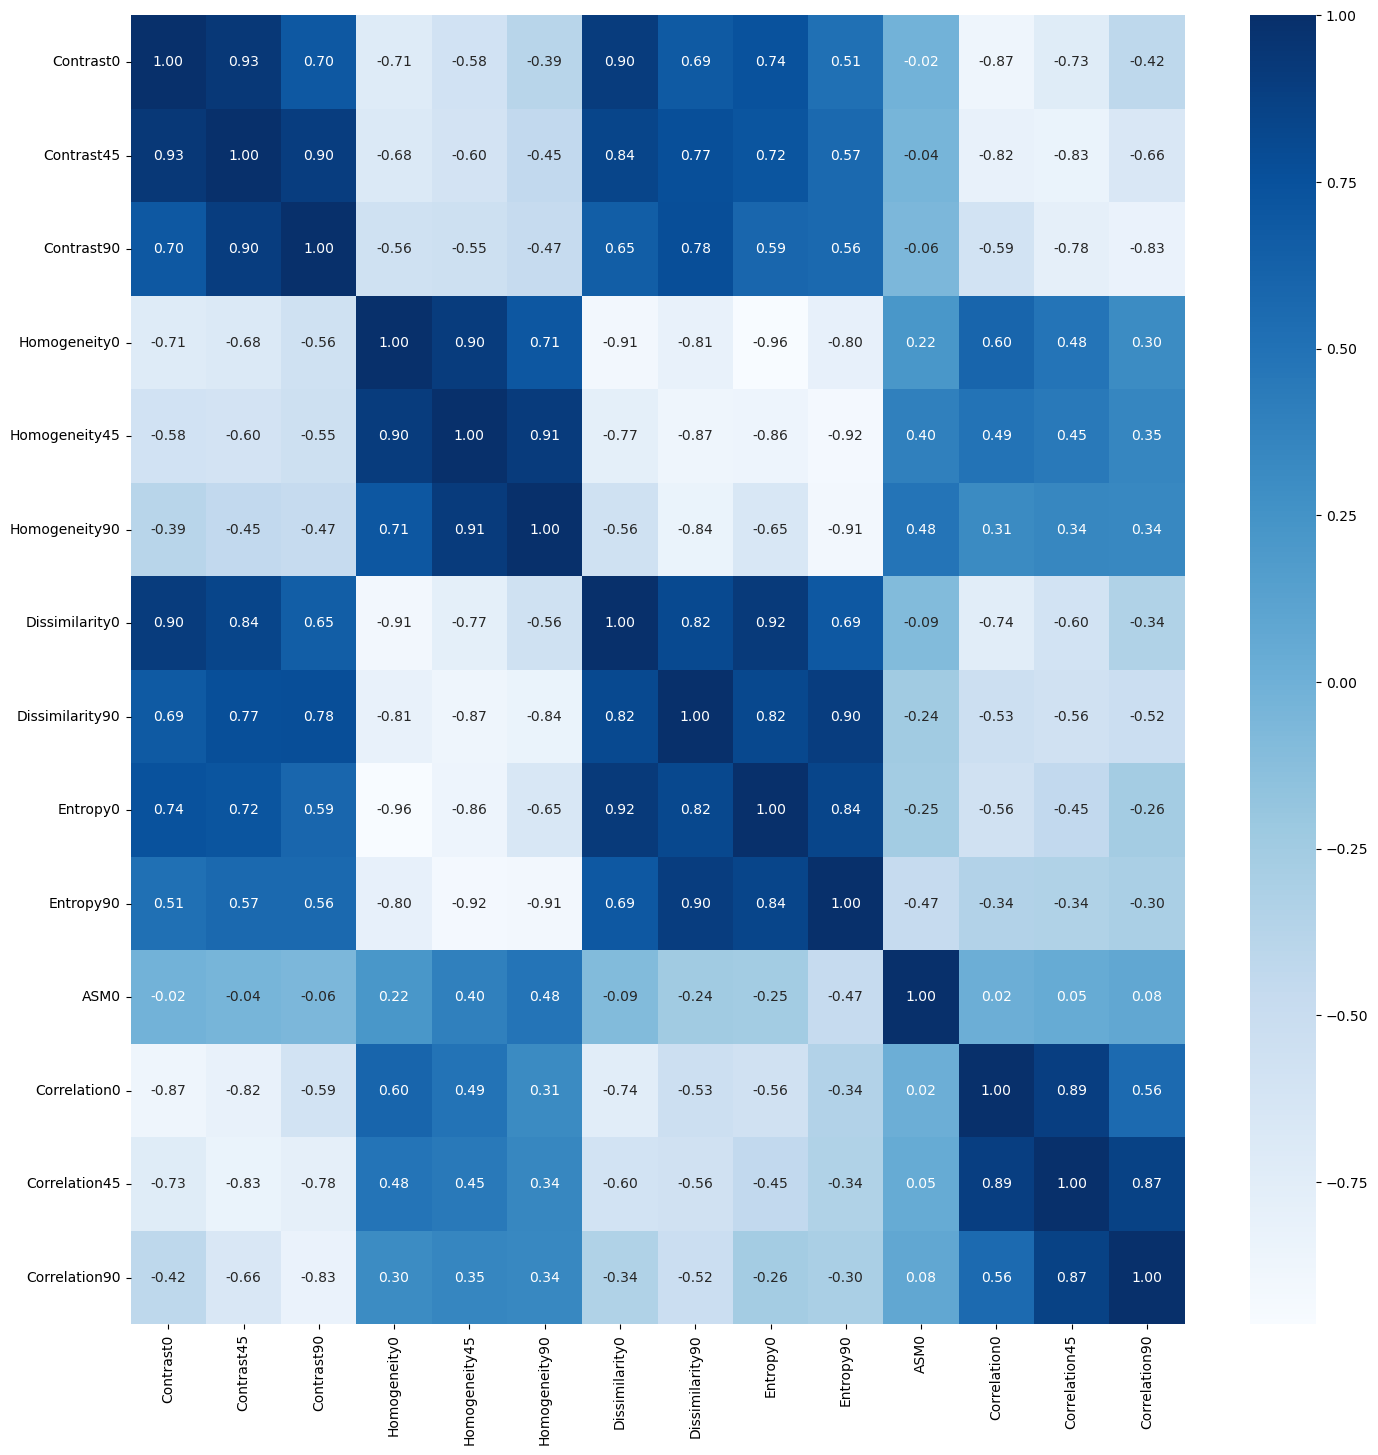

In [ ]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 14)
(40, 14)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [ ]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
rf.fit(X_train, y_train)

print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.95      0.99      0.97        79
   ScolFinal       0.99      0.95      0.97        81

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

[[78  1]
 [ 4 77]]
Accuracy: 0.96875

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       1.00      1.00      1.00        21
   ScolFinal       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

[[21  0]
 [ 0 19]]
Accuracy: 1.0


### Train SVM Classifier

In [ ]:
svm.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.82      0.96      0.88        79
   ScolFinal       0.96      0.79      0.86        81

    accuracy                           0.88       160
   macro avg       0.89      0.88      0.87       160
weighted avg       0.89      0.88      0.87       160

[[76  3]
 [17 64]]
Accuracy: 0.875

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.83      0.95      0.89        21
   ScolFinal       0.94      0.79      0.86        19

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

[[20  1]
 [ 4 15]]
Accuracy: 0.875


### Train KNN Classifier

In [ ]:
knn.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.88      0.94      0.91        79
   ScolFinal       0.93      0.88      0.90        81

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

[[74  5]
 [10 71]]
Accuracy: 0.90625

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.86      0.86      0.86        21
   ScolFinal       0.84      0.84      0.84        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[18  3]
 [ 3 16]]
Accuracy: 0.85


## Evaluation With Confusion Matrix

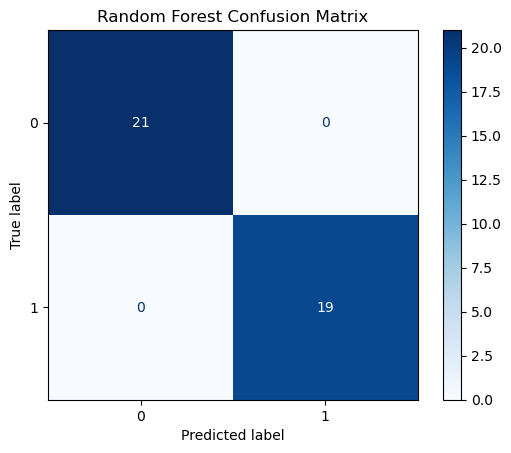

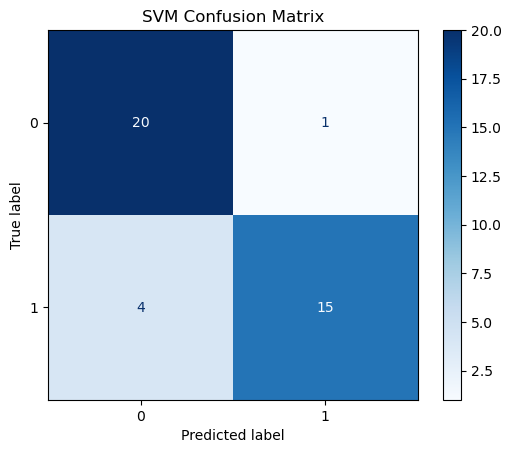

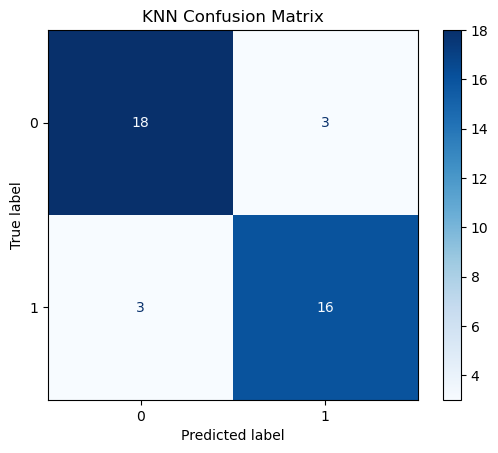

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")